In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from math import pi
from matplotlib import gridspec
import itertools
import time
import orbithunter as orb
import pandas as pd

# Hunting for Orbits 

Each spatiotemporal solution  to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation
\begin{equation}
F(u) = u_t + u_{xx}+ u_{xxxx} + \frac{1}{2}\partial_x u^2 = 0
\end{equation}

In order to find these solutions, we need initial guesses. These guess orbits can be produced in unsupervised and
supervised manners. The unsupervised method is to initialize a random spectrum of Fourier coefficients, and then modulate it
to represent the typical physical scales of the problem. When there are no obvious physical scales, this can be a dark art.
However, we are benefited by the variational formulation. Namely, we can exploit this by actually making *worse* initial conditions. By doing so, we are raising the cost. To demonstrate why this can be beneficial it is important to remember
how we are finding the solutions; namely, we are using descent/inexact Newton/quasi-Newton methods, typically with simple backtracking. Hunting can fail under a number of circumstances: the number of iterations exceeds the maximum allowed (varies
highly between methods), the step size becomes too small, or the residual is not decreasing enough (vanishing gradient). 

The analogy I like to use is thus: if you are trying to descend a mountain under the constraint that you can only ever move downwards, then it can be better to start higher up the mountain lest you get stuck at a cliff face. "higher" up the mountain is analogous to higher cost. The issue with starting higher up the mountain, is that certain components of the gradient can be incredibly large; especially the gradients of the dimensions of the configuration spoace.
Therefore I highly recommend including a rescaling operation (preconditioning when talking about solving linear systems)
that rescales these components. 

The "good" methods are highly dependent on problem; with square systems I would recommend solving the system directly when small enough, and with the sparse linear algebra methods when not. For the underdetermined systems I have found preconditioned "adjoint descent" which in the discrete case is just gradient descent.

Hunting
=======

I would like to present some tips in regards to the numerical optimization and wrapped SciPy routines.

1. The "custom" routines which do not perform a line search, 'adj', 'gd', 'lstsq', 'solve', 'newton_descent'
   can take steps which are too large; providing a value to the `step_size` keyword can be quite helpful. 
2. Rescaling can be very important if the magnitudes of the different gradient components are disparate from one another.
3. An alternative to rescaling gradient components corresponding to dimension parameters is to add an additional stage 
   of optimization and constrain the dimensions within that stage, acting as a preprocessing step. Typically, as the
   overall cost is decreased, these gradients become more "well behaved", in the sense that large distortions in domain sizes
   do not occur. 
4. The different options available to each method can drastically change the convergence, computation time, etc. for
   each method, and should always be considered/tested.

## Spectral modulation methods for the Kuramoto-Sivashinsky equation.

The listed pairs are the possible modulation strategies included in orbithunter for the KSE. What is not listed are
the hyperparameters, namely the "mean" and "variance" of the mollifiers. I use these terms because I feel like they are the
most understandable to a wider audience even though there is no statistics nor probability distributions to speak of.

In [2]:
space_tactics = ["gaussian", "laplace", "laplace_sqrt", "plateau_lienar", "exponential_linear", "flat_top", "random"]
time_tactics = ["gaussian", "laplace", "truncate", "flat_top", "laplace_plateau","random"]
print(f"There are {len(list(itertools.product(space_tactics, time_tactics)))} built in modulation combinations"
      f" for the KSE; this does not take hyperparameters into account.")
list(itertools.product(space_tactics, time_tactics))

There are 42 built in modulation combinations for the KSE; this does not take hyperparameters into account.


[('gaussian', 'gaussian'),
 ('gaussian', 'laplace'),
 ('gaussian', 'truncate'),
 ('gaussian', 'flat_top'),
 ('gaussian', 'laplace_plateau'),
 ('gaussian', 'random'),
 ('laplace', 'gaussian'),
 ('laplace', 'laplace'),
 ('laplace', 'truncate'),
 ('laplace', 'flat_top'),
 ('laplace', 'laplace_plateau'),
 ('laplace', 'random'),
 ('laplace_sqrt', 'gaussian'),
 ('laplace_sqrt', 'laplace'),
 ('laplace_sqrt', 'truncate'),
 ('laplace_sqrt', 'flat_top'),
 ('laplace_sqrt', 'laplace_plateau'),
 ('laplace_sqrt', 'random'),
 ('plateau_lienar', 'gaussian'),
 ('plateau_lienar', 'laplace'),
 ('plateau_lienar', 'truncate'),
 ('plateau_lienar', 'flat_top'),
 ('plateau_lienar', 'laplace_plateau'),
 ('plateau_lienar', 'random'),
 ('exponential_linear', 'gaussian'),
 ('exponential_linear', 'laplace'),
 ('exponential_linear', 'truncate'),
 ('exponential_linear', 'flat_top'),
 ('exponential_linear', 'laplace_plateau'),
 ('exponential_linear', 'random'),
 ('flat_top', 'gaussian'),
 ('flat_top', 'laplace'),
 ('

Just to get an idea into the "look" of each modulation and the subsequent (crude) optimization result

In [3]:
st, tt = list(itertools.product(space_tactics, time_tactics))[0]
orbit = orb.OrbitKS(parameters=(100, 44, 0.)).populate(attr='state', seed=5, spatial_modulation='laplace_sqrt',
                                                   xscale=44/(2*pi*np.sqrt(2)), xvar=2, 
                                                   tvar=1, tscale=1, temporal_modulation='gaussian')

Plot the spatiotemporal mode spectrum; y-axis is the temporal mode index, x-axis is space. 

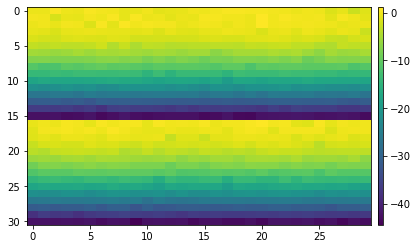

In [4]:
orbit.mode_plot()

Plot the physical field corresponding to this spectrum, $u(t,x)$

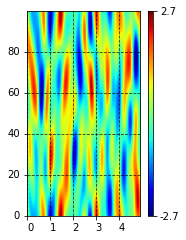

In [5]:
orbit.plot(padding=True)

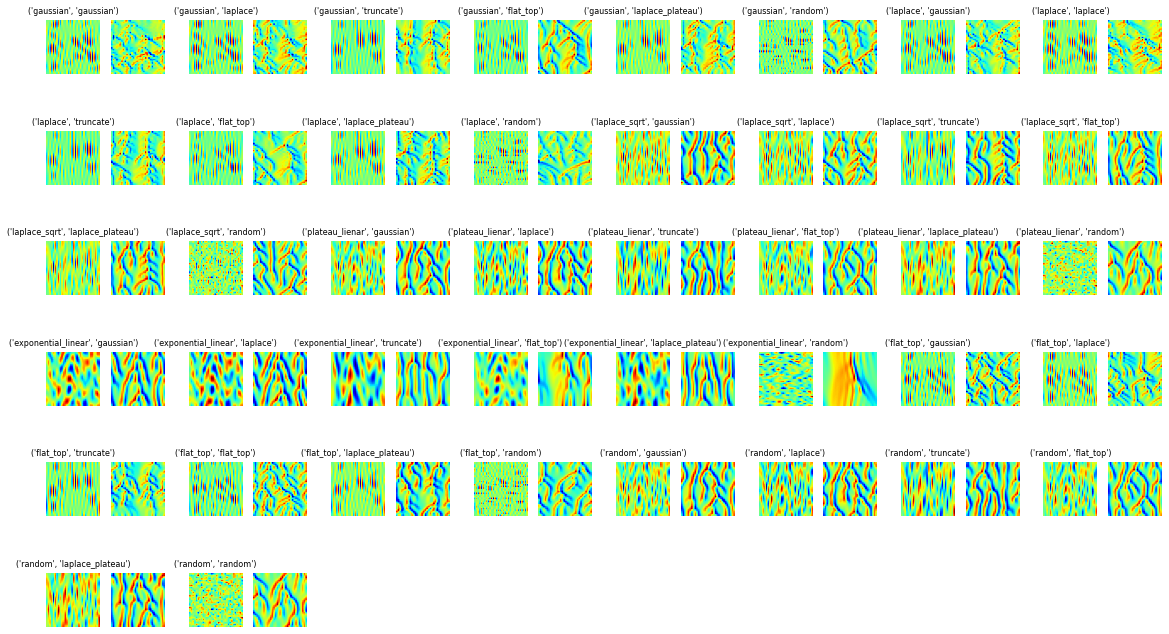

In [6]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(84//8, 8)
for i, (st, tt) in enumerate(itertools.product(space_tactics, time_tactics)):
    example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5, spatial_modulation=st, xscale=44/pi,
                                                                   temporal_modulation=tt, xshift='sqrt').rescale(5)
    
    result = orb.hunt(example_orbit, preconditioning=[True, False], methods=('adj', 'lsmr'),
                      maxiter=[10000, 10], scipy_kwargs={"atol":1e-4,"btol":1e-4})
    gsi = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i])
    ax = plt.subplot(gsi[0])
    ax2 = plt.subplot(gsi[1])
    ax.imshow(example_orbit.transform(to='field').state, cmap='jet')
    ax2.imshow(result.orbit.transform(to='field').state, cmap='jet')
    ax.axis('off')
    ax.set_title((st, tt), fontsize=8)
    ax2.axis('off')

plt.show()

Compare these results with a random solution to see which ones produced good results (note that the actual number of iterations is far fewer than I would recommend using)

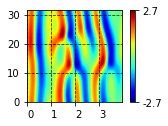

In [7]:
np.random.seed(22)
np.random.choice(orb.read_h5('./data/OrbitKS.h5')).plot(padding=True)

      
# How flexible and how much control does orbithunter give me?

Why should you use orbithunter instead of just using SciPy or NumPy or ... directly? One of the main design goal was flexibility and usability. How do you solve $F(x)=0$ and $1/2 |F(x)|^2 = 0$? The root solving problem can be solved by solving
the linear Newton system $\nabla F \delta x = - F$ iteratively, that is, $x_{n} = x_{n-1} - (\nabla F)^{-1} F$ iteratively (with backtracking a step size $\tau$ is also included on the second term. Alternatively, we can find minimizers of $1/2 |F|^2$ by finding directions of descent; those which decrease its value. Ok, well how do we do all of that? We can either write a custom algorithm or leverage smart people's results and use, for example, SciPy. 

Ok well then this begs the question: what do we need to use SciPy's algorithms? Well it depends. A lot. Sometimes you have to construct a matrix. Sometimes you need to provide a callable function. Sometimes you need to provide a callable function, its jacobian, and Hessian. Sometimes these methods return a `vector`, sometimes they return a `tuple` of runtime information, sometime they return an `OptimizeResult`. What if your cost function has extra arguments which depend on the current state but is too hard to update within the SciPy routines? What if you would want to exit and re-enter these algorithms? Modify the default arguments? 

The point I am trying to make is that I have tried to do the hard work for you by wrapping all of these routines with the orbithunter api. Now, all you need to do is pass `Orbit` (or subclass) instances, the methods you want to use, and the extra keyword arguments therein. 

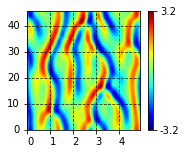

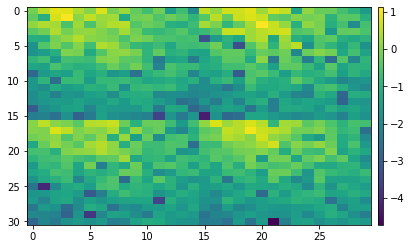

The numerical optimization took 171.46712636947632 seconds to complete 100000 iterations for each method


In [8]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5,
                                                              spatial_modulation='plateau_linear',
                                                              xscale=44/pi,
                                                               temporal_modulation='laplace_plateau',
                                                              xshift='sqrt').rescale(5)
result0 = orb.hunt(example_orbit,
                  preconditioning=True,
                  methods='adj',
                  verbose=False,
                  maxiter=100000,
                  pexp=(1,4)
                  )
t1 = time.time_ns()/10**9
result0.orbit.plot(padding=True)
result0.orbit.mode_plot()
print(f"The numerical optimization took {t1-t0} seconds to complete {result0.maxiter} iterations for each method")

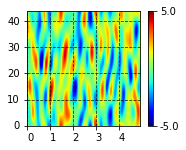

0.09304040736008219


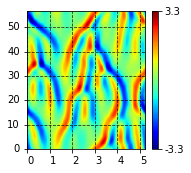

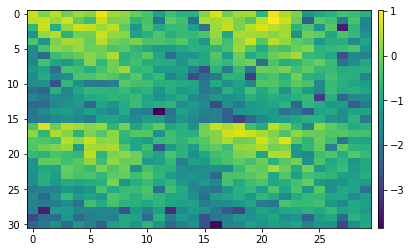

In [9]:
example_orbit.plot(padding=True)
print(result.orbit.cost())
result.orbit.plot(padding=True)
result.orbit.mode_plot()

dimensions (85.29406743837532, 46.54934604026858)
The numerical optimization took 79.17050242424011 seconds to complete [10000, 1000] iterations for each method
The residual of the optimization result is 0.01298898496314794


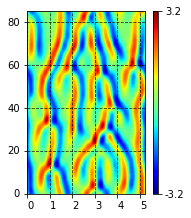

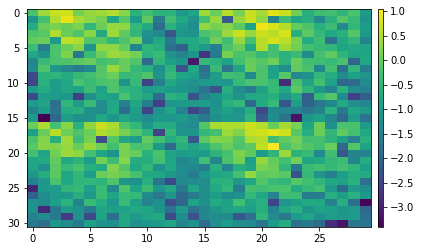

In [17]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5, spatial_modulation='plateau_linear', xscale=44/pi,
                                                               temporal_modulation='laplace_plateau', xshift='sqrt').rescale(5)
result = orb.hunt(example_orbit, preconditioning=[True, False], methods=('adj', 'lsmr'), verbose=False,
                  maxiter=[10000, 1000], scipy_kwargs={"atol":1e-4,"btol":1e-4})
t1 = time.time_ns()/10**9

print(f"dimensions {result.orbit.dimensions()}")
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")
print(f"The residual of the optimization result is {result.orbit.cost()}")
result.orbit.plot(padding=True)
result.orbit.mode_plot()

In [18]:
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")

The numerical optimization took 79.17050242424011 seconds to complete [10000, 1000] iterations for each method


# Why is this useful?

For those unfamiliar with the field of nonlinear dynamics and chaos, all we have shown so far is randomly initialized numbers
and the results of some crude optimization. 

The point is that most studies of the KSE have been on relatively small computational domains (L=22 and L=38.5 in the antisymmetric subspace for two examples). Additionally, exponential instability in the dynamical systems formulation means that
***no one*** (to my knowledge) has been able to find unstable periodic orbits from random noise. Additionally to the extent of my knowledge, no one has even considered allowing the spatial domain size to vary. 

Orbithunter does all three of these by default, as I will show in the next example. First, construct an initial guess on a
very large spatiotemporal domain: $(T,L)=(500,\;55(2\pi\sqrt{2})$; remember, $L=22$ is a common size. 

In [14]:
small_final, final, initial, final_2, initial_2 = orb.read_h5('./data/large_hunting_example.h5')

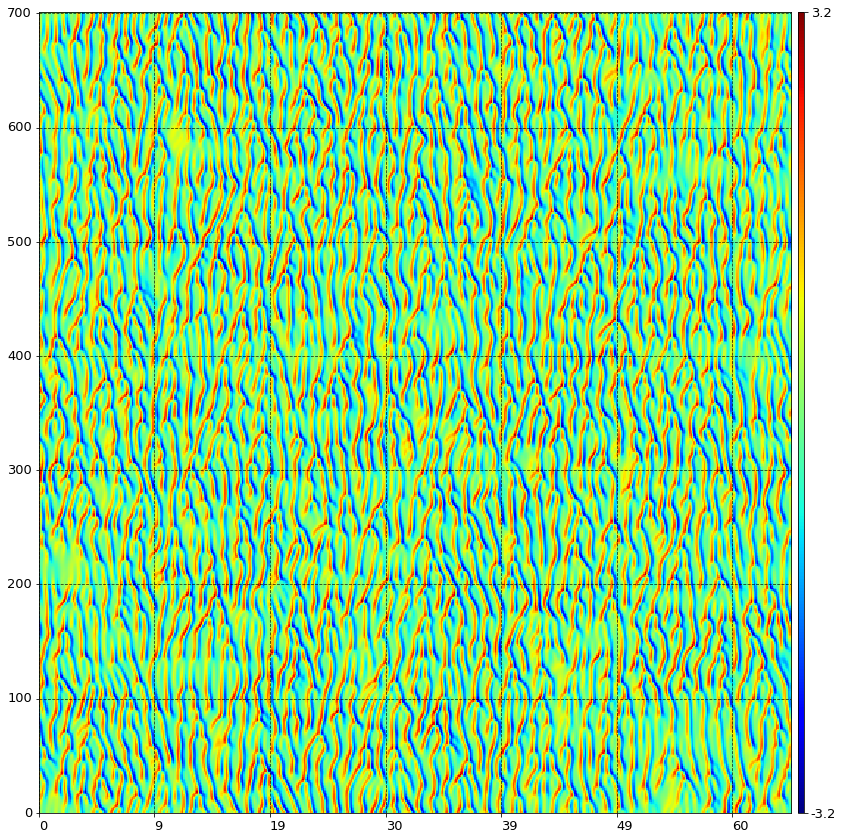

In [15]:
final_2.plot()

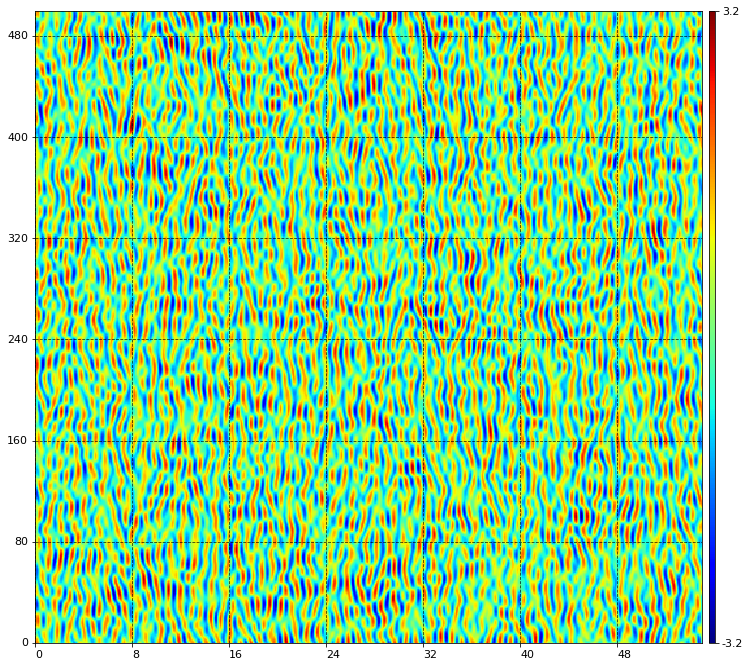

In [16]:
initial_2.plot()

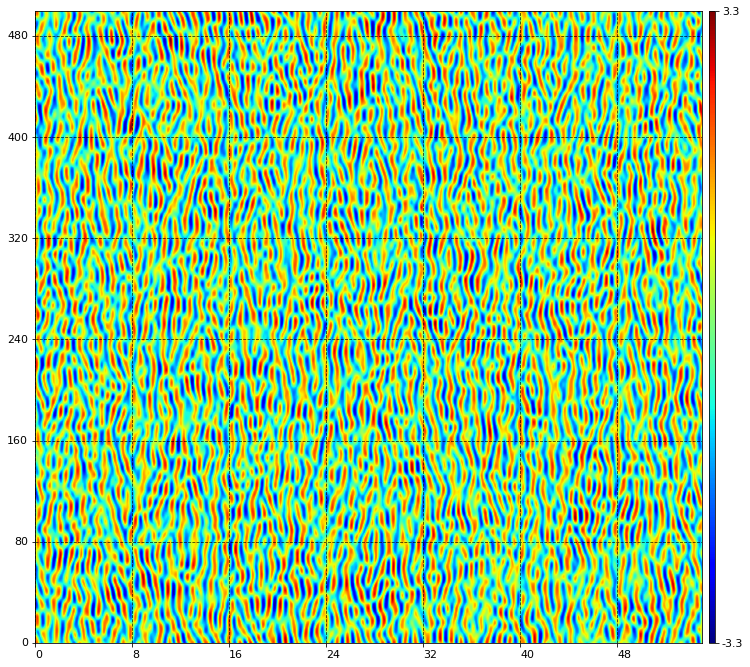

The initial guess' dimensions are (500.0, 488.71712319742034) and has cost residual 35638.82841245845


In [19]:
initial.plot(padding=True, filename="large_orbit_initial.pdf")
print(f"The initial guess' dimensions are {initial.dimensions()} and has cost residual {initial.cost()}")

To give an idea of scale, the following unmasked region represents a "typical" size of orbit, $(T, L)=(100,\: 22\:/\:(2\pi\sqrt 2))$

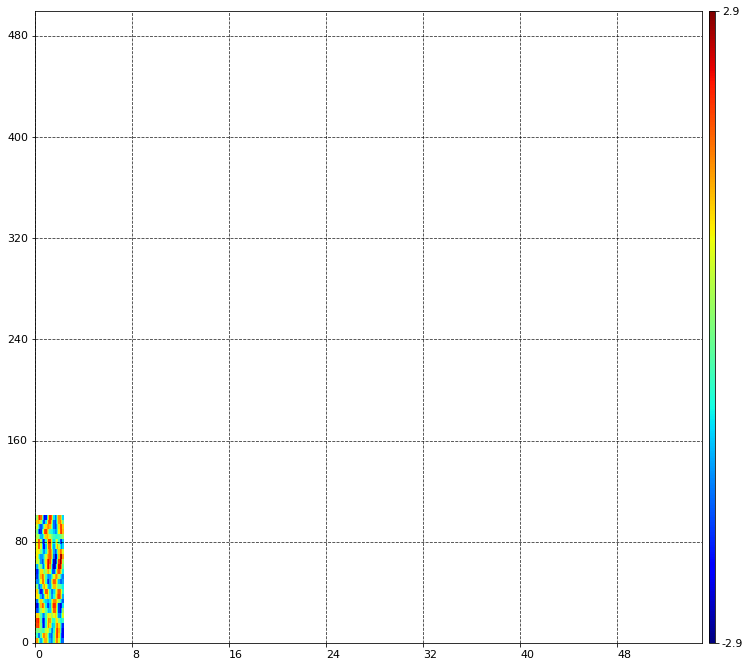

In [20]:
orb.clipping_mask(initial, (((0, 100), (0, 22/(2*pi*np.sqrt(2)))),)).plot(padding=False)

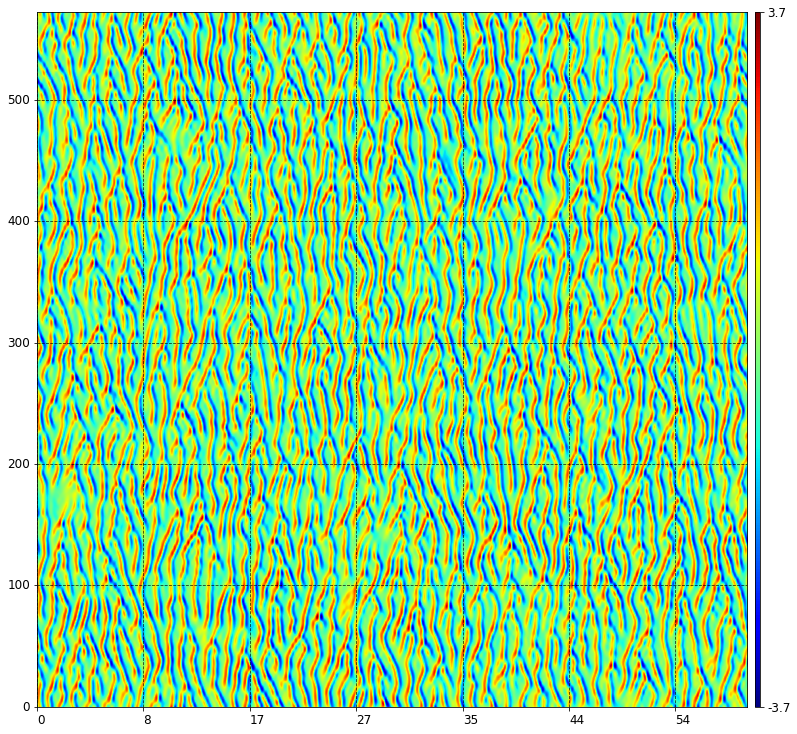

The 'final' orbit's dimensions are (572.8110716137107, 533.9495077765063) and has cost residual 17.603890012130996
This resulted from approximately 30 minutes of optimization (cg_min)


In [21]:
small_final.plot(padding=True, filename="large_orbit_final.pdf")
print(f"The 'final' orbit's dimensions are {small_final.dimensions()} and has cost residual {small_final.cost()}")
print(f"This resulted from approximately 30 minutes of optimization (cg_min)")

Once again, a domain of "typical" size is shown for comparison.

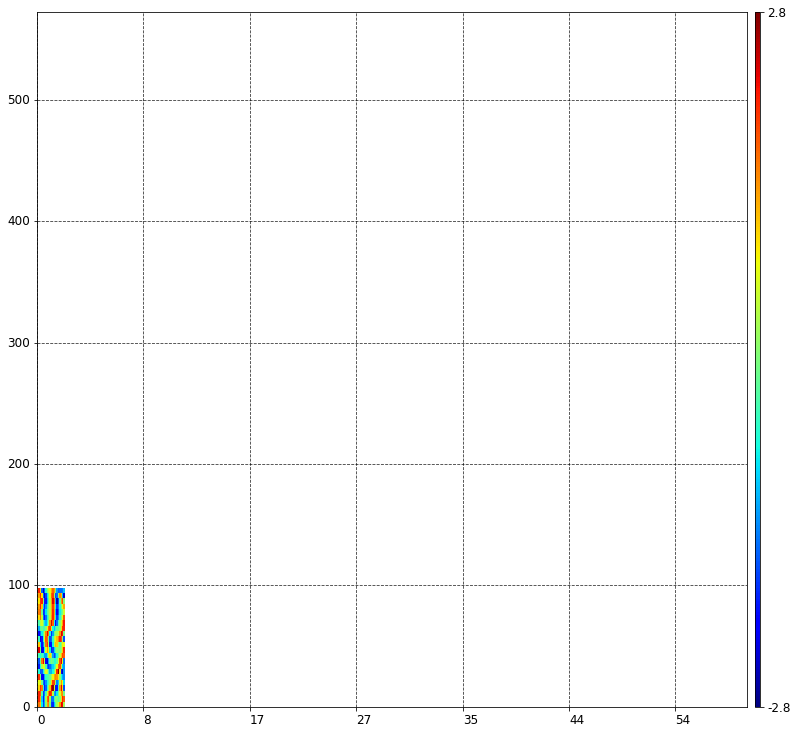

In [22]:
orb.clipping_mask(small_final, (((0, 100), (0, 22/(2*pi*np.sqrt(2)))),)).plot(padding=False)

Now, just for fun, I let the following run with the knowledge that it was going to take a very long time; let's see how close
I can get to a periodic orbit at this size. Depending on the tolerance this could be the largest periodic orbit ever found for the KSe.
It has 250k computational degrees of freedom, all of which are highly coupled in a nonlinear manner. 

# How do I choose a numerical method?

In the world of data scientists, "there is no free lunch" is a common idiom. Which methods work best for a problem is
highly dependent on the problem; the only general recommendations are:

    1. Never use a method which constructs matrices on large problems, you'll run out of memory.
    2. Do NOT use the following for the KSE: diagbroyden, cobyla, slsqp, nelder-mead, powell, excitingmixing, linearmixing,
       broyden1, broyden2, anderson, df-sane. They either perform incredibly poorly or take an incredible amount of time.
    3. For "bad" initial conditions: use preconditioning. especially on the derivatives w.r.t. dimensional parameters.
       Preconditioning is not built in; it is on you. I highly recommend including a flag for preconditioning in your
       `rmatvec` method, as then it can be enabled for adjoint descent / gradient descent / other methods. 


I would like to present some tips in regards to the numerical optimization and wrapped SciPy routines.

    1. The "custom" routines which do not perform a line search, 'adj', 'gd', 'lstsq', 'solve', 'newton_descent'
       can take steps which are too large; providing a value to the `step_size` keyword can be quite helpful. 
    2. Rescaling can be very important if the magnitudes of the different gradient components are disparate from one another.
    3. An alternative to rescaling gradient components corresponding to dimension parameters is to add an additional stage 
       of optimization and constrain the dimensions within that stage, acting as a preprocessing step. Typically, as the
       overall cost is decreased, these gradients become more "well behaved", in the sense that large distortions in domain sizes
       do not occur. 
    4. The different options available to each method can drastically change the convergence, computation time, etc. for
       each method, and should always be considered/tested.



It is hard to quantify the performances of each method; the most important consideration to keep in mind is how they scale with memory. This is compounded with the fact that SciPy's default arguments 

In [23]:
import pandas as pd

The original orbit


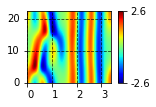

The original orbit plus some noise


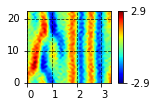

In [24]:
np.random.seed(0)
initial = orb.read_h5('./data/OrbitKS.h5')[77].resize(40, 40).transform(to='field')
print("The original orbit")
initial.plot(padding=True)
initial += 0.2 * np.random.randn(*initial.shape)
initial.transform(to='modes', inplace=True)
print("The original orbit plus some noise")
initial.plot(padding=True)

In [25]:
df = pd.read_csv('./data/numerical_time_trials.csv', index_col=0)
df.columns = ['time', 't', 'x']+df.columns.tolist()[3:]
df.columns = [col.strip() for col in df.columns]
df.loc[:,'t'] = df.loc[:,'t'].apply(lambda x : x.split('(')[1]).values
df.loc[:,'x'] = df.loc[:,'x'].apply(lambda x : x.split(')')[0]).values

In [74]:
num_meth_stats = pd.read_csv("numerical_method_times.txt")
num_meth_stats.groupby(['method', 'preconditioning']).mean().sort_values(by='cost')

time           t          x        cost  \
method   preconditioning                                                  
tnc      False              0.197374  118.786431  77.215149    0.000002   
         True               0.201002  118.786431  77.215149    0.000002   
lm       True             114.959029  118.786431  77.215149    0.000018   
         False            111.165002  118.786431  77.215149    0.000018   
l-bfgs-b True               0.586987  118.786431  77.215149    0.011266   
...                              ...         ...        ...         ...   
bicg     False              0.136000  118.786431  77.215149  532.670774   
bicgstab False              0.135162  118.786431  77.215149  595.860770   
bicg     True               0.131000  118.786431  77.215149  668.549214   
qmr      True               0.137526  118.786431  77.215149  674.028553   
bicgstab True               0.129998  118.786431  77.215149  687.864645   

                          cost_reduction  cost_reduction_per_second  \
method   preconditioning                                              
tnc      False                701.787592                3555.621394   
         True                 701.787592                3491.439573   
lm       True                 701.787576                   6.104676   
         False                701.787576                   6.313026   
l-bfgs-b True                 701.776328                1195.556811   
...                                  ...                        ...   
bicg     False                169.116820                1243.506782   
bicgstab False                105.926824                 783.704797   
bicg     True                  33.238380                 253.727549   
qmr      True                  27.759042                 201.846070   
bicgstab True                  13.922950                 107.100895   

                          cost_reduction_per_step  
method   preconditioning                           
tnc      False                         701.787592  
         True                          701.787592  
lm       True                          701.787576  
         False                         701.787576  
l-bfgs-b True                          701.776328  
...                                           ...  
bicg     False                         169.116820  
bicgstab False                         105.926824  
bicg     True                           33.238380  
qmr      True                           27.759042  
bicgstab True                           13.922950  

[74 rows x 7 columns]

In [97]:
num_meth_stats = pd.read_csv("numerical_method_times.txt")

num_meth_stats= num_meth_stats.replace('None', '0')
num_meth_stats = num_meth_stats.astype(dict(zip(num_meth_stats.columns[1:-2], len(num_meth_stats.columns[1:-2])*[float])))
num_meth_stats.groupby(['method','constrained']).mean().sort_values(by='cost_reduction_per_second', ascending=False).iloc[:50, :-2]

time           t          x        cost  \
method               constrained                                                
newton-cg            True         0.049501  118.786431  77.215149   10.370421   
trust-ncg            True         0.062061  118.786431  77.215149    3.785280   
newton-cg            False        0.066784  121.413956  79.706855    6.208877   
trust-constr_cs      True         0.074402  118.786431  77.215149   22.234779   
trust-krylov         True         0.080103  118.786431  77.215149    3.785280   
trust-ncg            False        0.083861  123.250973  80.351643    3.671075   
trust-constr_cs      False        0.093697  119.897673  82.279814   20.774644   
trust-constr         True         0.097001  118.786431  77.215149   24.087620   
trust-krylov         False        0.101498  123.250973  80.351643    3.671075   
adj                  True         0.103890  118.786431  77.215149   68.641499   
trust-constr         False        0.125879  122.016324  80.625966   23.535713   
minres               False        0.128863  121.552667  77.852661   49.832842   
trust-ncg_cs         False        0.142856  121.004826  81.385701    8.111355   
trust-constr_2-point True         0.152798  118.786431  77.215149   32.674141   
adj                  False        0.155627  120.414661  82.124288   67.438353   
trust-constr_2-point False        0.181699  119.438584  81.291434   39.487387   
trust-ncg_cs         True         0.191001  118.786431  77.215149    4.965309   
trust-krylov_cs      False        0.193678  121.004826  81.385701    8.111355   
tnc                  True         0.202136  118.786431  77.215149    0.000002   
minres               True         0.074003  118.786431  77.215149  456.481663   
trust-ncg_2-point    False        0.234965  122.257999  80.343210    4.647202   
                     True         0.253501  118.786431  77.215149    5.158701   
krylov               True         0.230878  118.786431  77.215149   91.079622   
trust-krylov_cs      True         0.265662  118.786431  77.215149    4.965309   
trust-constr_3-point True         0.259563  118.786431  77.215149   32.674167   
krylov               False        0.242249  118.786431  77.215149   91.079395   
bfgs                 True         0.267902  118.786431  77.215149   95.317341   
trust-krylov_2-point False        0.319681  122.053115  79.563944    4.198531   
trust-constr_3-point False        0.307643  119.438584  81.291434   39.487389   
bfgs                 False        0.281459  119.581320  77.114620   98.882417   
trust-ncg_3-point    True         0.346624  118.786431  77.215149    5.158700   
bicg                 False        0.339737  123.221704  77.736841   58.704556   
tnc                  False        0.371153  419.055162  81.668693    0.000002   
qmr                  False        0.342774  122.133299  77.798653   54.815471   
trust-krylov_2-point True         0.373161  118.786431  77.215149    5.432745   
trust-ncg_3-point    False        0.373472  122.257999  80.343210    4.647202   
bicgstab             False        0.359949  123.452268  77.754536   58.211468   
qmr                  True         0.133335  118.786431  77.215149  495.592687   
trust-krylov_3-point False        0.511523  122.053115  79.563943    4.198530   
                     True         0.527920  118.786431  77.215149    5.432745   
l-bfgs-b             True         0.575278  118.786431  77.215149    0.011266   
                     False        0.618528  137.359026  77.982320    0.018333   
cg_min               False        0.662294  127.350760  78.096163    0.017779   
lsmr                 True         0.667642  118.786431  77.215149    3.464944   
solve                True         0.220680  118.786431  77.215149  479.733489   
lsqr                 True         0.710026  118.786431  77.215149    9.931751   
bicg                 True         0.139027  118.786431  77.215149  600.609994   
lsqr                 False        0.945747  147.998146  78.853697    

First compare the numerical methods with and without preconditioning; on average, preconditioning seems to hurt the convergence
of computation.

In [69]:
(num_meth_stats[~num_meth_stats.preconditioning].drop(columns='preconditioning')/num_meth_stats[num_meth_stats.preconditioning].drop(columns='preconditioning')).mean()

time                         0.943829
t                            1.000000
x                            1.000000
cost                         0.865783
cost_reduction               1.716747
cost_reduction_per_second    2.163580
cost_reduction_per_step      1.716747
dtype: float64

In [70]:
num_meth_stats[~num_meth_stats.preconditioning].sort_values(by=['cost_reduction_per_second', 'cost'], ascending=False)

time           t          x        cost  \
method                                                                
newton-cg               0.050002  118.786431  77.215149   10.370421   
trust-ncg               0.064209  118.786431  77.215149    3.785280   
trust-ncg_3-point       0.081643  118.786431  77.215149    5.158700   
trust-krylov            0.087998  118.786431  77.215149    3.785280   
adj_prec                0.097999  118.786431  77.215149    7.819562   
trust-constr            0.101000  118.786431  77.215149   24.087620   
adj                     0.103998  118.786431  77.215149    7.819562   
trust-constr_3-point    0.109008  118.786431  77.215149   32.674167   
trust-krylov_3-point    0.165848  118.786431  77.215149    5.432745   
minres                  0.073997  118.786431  77.215149  416.109903   
trust-constr_cs         0.189698  118.786431  77.215149   22.234779   
tnc                     0.197374  118.786431  77.215149    0.000002   
qmr                     0.133000  118.786431  77.215149  317.156821   
krylov                  0.232116  118.786431  77.215149   91.079622   
trust-constr_2-point    0.270697  118.786431  77.215149   32.674141   
trust-ncg_cs            0.323632  118.786431  77.215149    4.965309   
bfgs                    0.306998  118.786431  77.215149   95.317341   
trust-ncg_2-point       0.386213  118.786431  77.215149    5.158701   
trust-krylov_cs         0.453848  118.786431  77.215149    4.965309   
bicg                    0.136000  118.786431  77.215149  532.670774   
trust-krylov_2-point    0.563948  118.786431  77.215149    5.432745   
l-bfgs-b                0.596047  118.786431  77.215149    0.011266   
lsmr                    0.643422  118.786431  77.215149    3.464944   
solve                   0.206875  118.786431  77.215149  479.733489   
lsqr                    0.675271  118.786431  77.215149    9.931751   
cg_min                  0.794585  118.786431  77.215149    0.041073   
bicgstab                0.135162  118.786431  77.215149  595.860770   
gmres                   1.371347  118.786431  77.215149  127.665889   
gcrotmk                 1.770443  118.786431  77.215149  113.979626   
lgmres                  2.268857  118.786431  77.215149  124.367613   
lstsq                   0.930378  118.786431  77.215149  479.733489   
cgs                     1.549648  118.786431  77.215149  389.767882   
cg                      2.068205  118.786431  77.215149  488.372278   
hybr                    8.690150  118.786431  77.215149    3.134833   
trust-exact            10.190036  118.786431  77.215149    4.013322   
dogleg                 37.140648  118.786431  77.215149    2.976046   
lm                    111.165002  118.786431  77.215149    0.000018   

                      cost_reduction  cost_reduction_per_second  \
method                                                            
newton-cg                 691.417173               13827.895092   
trust-ncg                 698.002314               10870.869622   
trust-ncg_3-point         696.628894                8532.661348   
trust-krylov              698.002314                7932.054052   
adj_prec                  693.968032                7081.371781   
trust-constr              677.699974                6709.896049   
adj                       693.968032                6672.916643   
trust-constr_3-point      669.113427                6138.187204   
trust-krylov_3-point      696.354849                4198.765020   
minres                    285.677691                3860.639894   
trust-constr_cs           679.552816                3582.292583   
tnc                       701.787592                3555.621394   
qmr                       384.630773                2891.952574   
krylov                    610.707972                2631.041203   
trust-constr_2-point      669.113453                2471.820313   
trust-ncg_cs              696.822285                2153.128412   
bfgs                      606.470253                

In [ ]:
num_meth_stats = pd.read_csv("numerical_method_times_without_constraints.txt", index_col=0)

# Happy hunting!